In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.plots import Hodograph
from metpy.units import units
from matplotlib.cm import get_cmap

C:\Users\culle\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\culle\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\culle\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
rawData = './T3_1800_12132020_Artemis_Rerun.txt'

In [3]:

#Grab header information such as station name date etc...
def headerData(rawData, encoding='ISO-8859-1'):
    start_line = None
    end_line = None
    with open(rawData, 'r', encoding=encoding) as file:
        headerDataHit = False
        for i, line in enumerate(file):
            if 'Launch Date:' in line:
                headerDataHit = True
            elif headerDataHit and 'Profile Data:' in line:
                end_line = i 
                break
            elif headerDataHit and line.strip() and start_line is None:
                #Grabs line where profile data exists
                start_line = i  - 1
    return start_line, end_line
                
    
#Grab profile data which is what contains the raw Radiosonde data
def grabProfileData(rawData, encoding='ISO-8859-1'):
    start_line = None
    end_line = None
    with open(rawData, 'r', encoding=encoding) as file:
        pfDataHit = False
        for i, line in enumerate(file):
            if 'Profile Data' in line:
                pfDataHit = True
            elif pfDataHit and 'Tropopauses:' in line:
                #Mark the line before Tropopauses footer
                end_line = i - 1
                break
            elif pfDataHit and line.strip() and start_line is None:
                #Grabs line where profile data exists
                start_line = i
    return start_line, end_line
    
    
#Grab troposphere data which is at the footer of the file
def tropoData(rawData, encoding='ISO-8859-1'):
    start_line = None
    end_line = None
    with open(rawData, 'r', encoding=encoding) as file:
        tropoDataHit = False
        for i, line in enumerate(file):
            if '1. Tropopause:' in line:
                tropoDataHit = True
            elif tropoDataHit and 'Reason of Stop Sounding:' in line:
                end_line = i 
                break
            elif tropoDataHit and line.strip() and start_line is None:
                #Grabs line where profile data exists
                start_line = i -1
    return start_line, end_line
                
    

In [4]:
#Uses appropriate functions to apply the profiles into dataframes if there is some error with the format of the file it will not create the dataframe
data_start_line, data_end_line = headerData(rawData)
if data_start_line is not None and data_end_line is not None:
    nrows_to_read = data_end_line - data_start_line
    header_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1', header=None)

data_start_line, data_end_line = grabProfileData(rawData)
if data_start_line is not None and data_end_line is not None:
    nrows_to_read = data_end_line - data_start_line
    profile_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1')
    #profile_df.columns += profile_df.iloc[0]
    profile_df.rename(columns=lambda x: x.strip(), inplace=True)
    profile_df = profile_df[1:]


data_start_line, data_end_line = tropoData(rawData)
if data_start_line is not None and data_end_line is not None:
    nrows_to_read = data_end_line - data_start_line
    tropo_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1')

In [5]:
header_df = header_df.dropna(axis=1, how="all")
header_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Launch Date:,,,"Sunday, 13 December 2020",,,,Launch Time:,,,17:59:56,,,End of Ascent:,,,01:37:57
1,Station name:,,,OKSTATE USRI,,,,Serialnumber:,,,20028048,None,None,None,None,None,None
2,Ground values:,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Pressure:,,,1024.5 hPa,,,,Temperature:,,,16.8 °C,,,Humidity:,,,58 %
4,Wind Direction:,,,198 °,,,,Wind Speed:,,,5 m/s,,,Cloud group:,,,9////
5,Position:,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Longitude:,,,-73.160 °,,,,Latitude:,,,-39.236 °,,,Altitude:,,,3 m
7,Staff:,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,Company:,,,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None
9,Operator:,,,,,,,NaN,None,None,None,None,None,None,None,None,None


In [39]:
#Converts column to whatever integer equivalent float / int
for col in profile_df.select_dtypes(include=['object']).columns:
    profile_df[col] = pd.to_numeric(profile_df[col], downcast='integer')

#Calculates the difference between followings alts
profile_df['diff'] = profile_df['Alt'].diff()
peak_index = profile_df[profile_df['diff'] < 0].first_valid_index()
#Drop rows after peak and drop diff column
if peak_index is not None:
    profile_df = profile_df.loc[:peak_index - 1]
profile_df = profile_df.drop(columns=['diff'])
profile_df

,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Alt,Geopot,MRI,RI,Dewp.,Virt. Temp,Rs,Elevation,Azimuth,Range,D,Altitude Bin
1,0,1024.5,16.8,58,4.9,198,-73.160400,-39.236410,3,3,277.234,276.763,8.5,18.0,0.0,39.2,180,0,1.231139,1000
2,1,1023.5,16.7,58,4.9,200,-73.160259,-39.236324,12,11,278.454,276.649,8.5,17.8,8.5,30.0,53,18,1.230524,1000
3,2,1022.5,16.5,59,5.0,201,-73.160118,-39.236238,20,20,279.659,276.535,8.5,17.7,8.5,29.3,52,35,1.229909,1000
4,3,1021.5,16.4,59,5.1,203,-73.159977,-39.236153,28,28,280.880,276.422,8.5,17.6,8.5,29.1,52,53,1.229295,1000
5,4,1020.4,16.2,60,5.1,204,-73.159836,-39.236067,37,37,282.086,276.308,8.4,17.4,8.5,29.0,52,70,1.228682,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5855,5854,10.8,-42.3,3,25.0,88,-72.714997,-38.780770,30867,30700,4849.911,3.824,-69.3,-42.2,0.8,25.5,37,70846,0.016248,31000
5856,5855,10.8,-42.3,3,25.0,88,-72.715295,-38.780780,30868,30701,4850.036,3.823,-69.3,-42.2,0.8,25.5,37,70831,0.016246,31000
5857,5856,10.8,-42.3,3,25.1,88,-72.715593,-38.780790,30868,30702,4850.146,3.823,-69.3,-42.3,0.8,25.6,37,70816,0.016245,31000
5858,5857,10.8,-42.3,3,25.1,88,-72.715891,-38.780799,30869,30703,4850.271,3.822,-69.3,-42.3,0.8,25.6,37,70802,0.016244,31000


In [7]:
profile_df.dtypes

Time            int16
P             float64
T             float64
Hu              int32
Ws            float64
Wd              int16
Long.         float64
Lat.          float64
Alt             int16
Geopot          int16
MRI           float64
RI            float64
Dewp.         float64
Virt. Temp    float64
Rs            float64
Elevation     float64
Azimuth         int16
Range           int32
D             float64
dtype: object

In [8]:
def calcWindComps(speeds, directions):
    speeds = np.array(speeds)
    directions = np.array(directions)

    u = -speeds * np.sin(np.radians(directions))
    v = -speeds * np.cos(np.radians(directions))
    return u, v

Hodo = calcWindComps(profile_df['Ws'], profile_df['Wd'])
print(Hodo[0],Hodo[1])

[  1.51418317   1.67589875   1.79183945 ... -25.0847101  -25.0847101
 -25.0847101 ] [ 4.66017705  4.60449382  4.66790229 ... -0.87597724 -0.87597724
 -0.87597724]


In [9]:
#XY graph choose x  y axis, poly degree, and labels
def graph2d(x, y, deg, x_label, y_label, title):
    plt.figure()
    plt.scatter(x, y, s=5, label='Data Points')

    #best fit curve
    coeffs = np.polyfit(y, x, deg)  
    y_curve = np.linspace(y.min(), y.max(), 500)  
    x_curve = np.polyval(coeffs, y_curve) 

    plt.plot(x_curve, y_curve, 'r-', label='Best Fit Line')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    plt.show()

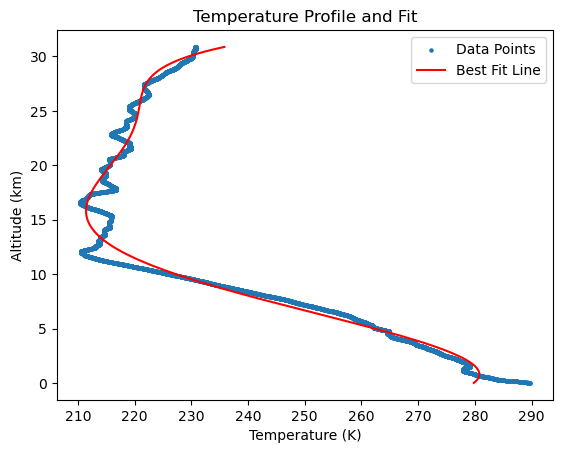

In [10]:
graph2d( profile_df['T']+273, profile_df['Alt']/1000 , 6,'Temperature (K)', 'Altitude (km)', 'Temperature Profile and Fit')

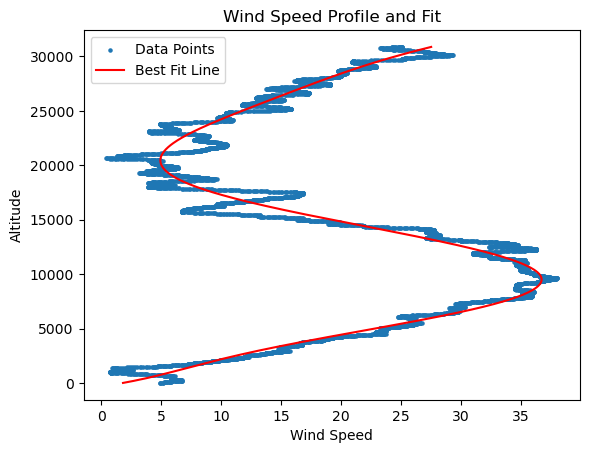

In [11]:
graph2d(profile_df['Ws'], profile_df['Alt'],8 ,'Wind Speed', 'Altitude', 'Wind Speed Profile and Fit')

In [61]:
def hodograph(compRange, lineWidth): 
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    hodo = Hodograph(ax, component_range = compRange)
    hodo.add_grid(increment=10)
    hodo.add_grid(increment=20, linestyle='-')

    #colormap
    cmap = get_cmap('viridis')
    norm = plt.Normalize(vmin=profile_df['Alt'].min(), vmax=profile_df['Alt'].max())

    #For eacch value graph it and color it based on altitude
    for i in range(len(Hodo[0])-1):
        segment_color = cmap(norm(profile_df['Alt'].iloc[i]))
        hodo.plot(Hodo[0][i:i+2], Hodo[1][i:i+2], color=segment_color, linewidth=lineWidth,
                label=f'{profile_df["Alt"].iloc[i]:.0f}-{profile_df["Alt"].iloc[i+1]:.0f} m')

    #create axis names and altitude bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label('Altitude (m)')
    ax.set_xlabel('U Component (m/s)')
    ax.set_ylabel('V Component (m/s)')
    plt.show()

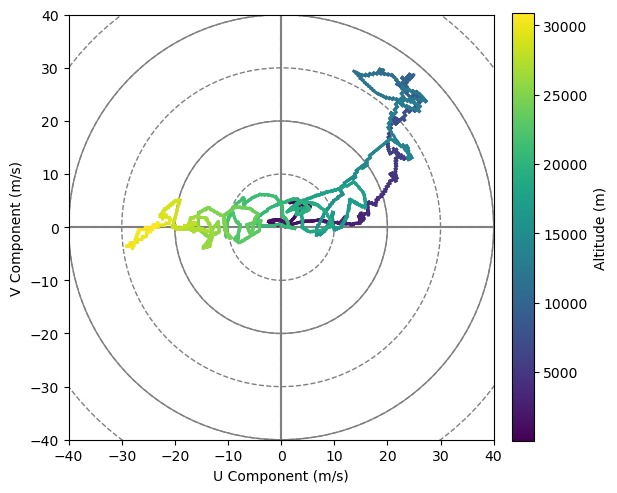

In [62]:
hodograph(40,2)

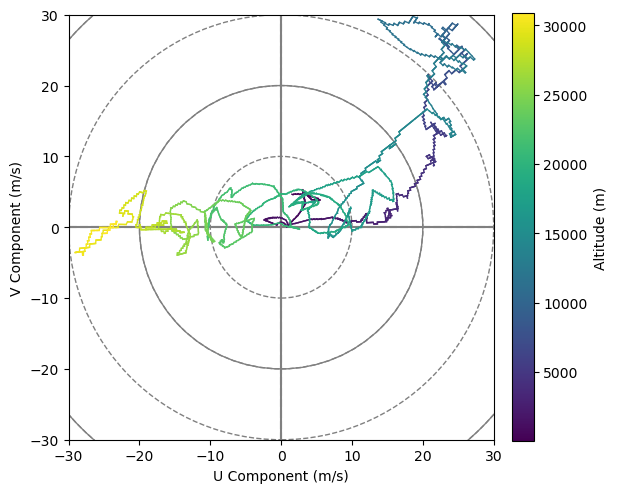

In [63]:
hodograph(30,1)

In [60]:
def resample_dataframe(df, altitude_interval=1000):
    #finds the max size of altitude and creates a 1000 interval of the altitude based on profile_df
    max_altitude = df['Alt'].max()
    bins = np.arange(0, max_altitude + altitude_interval, altitude_interval)
    labels = np.arange(altitude_interval, max_altitude + altitude_interval, altitude_interval)
    

    df['Altitude Bin'] = pd.cut(df['Alt'], bins=bins, labels=labels, include_lowest=True)
    
    #calc the mean temperature for each km
    resampled_df = df.groupby('Altitude Bin').agg({'T':'mean'}).reset_index()
    resampled_df['Altitude Bin'] = resampled_df['Altitude Bin'].astype(int)
    
    #adjust LE COLUUMN names
    resampled_df.rename(columns={'Altitude Bin': 'Alt', 'T': 'Mean Temperature'}, inplace=True)
    
    return resampled_df

resampled_df = resample_dataframe(profile_df)

#calc the lapse rate
resampled_df['Lapse Rate'] = resampled_df['Mean Temperature'].diff() 

C:\Users\culle\AppData\Local\Temp\ipykernel_25424\4266540393.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resampled_df = df.groupby('Altitude Bin').agg({'T':'mean'}).reset_index()


In [21]:
profile_df

,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Alt,Geopot,MRI,RI,Dewp.,Virt. Temp,Rs,Elevation,Azimuth,Range,D,Altitude Bin
1,0,1024.5,16.8,58,4.9,198,-73.160400,-39.236410,3,3,277.234,276.763,8.5,18.0,0.0,39.2,180,0,1.231139,1000
2,1,1023.5,16.7,58,4.9,200,-73.160259,-39.236324,12,11,278.454,276.649,8.5,17.8,8.5,30.0,53,18,1.230524,1000
3,2,1022.5,16.5,59,5.0,201,-73.160118,-39.236238,20,20,279.659,276.535,8.5,17.7,8.5,29.3,52,35,1.229909,1000
4,3,1021.5,16.4,59,5.1,203,-73.159977,-39.236153,28,28,280.880,276.422,8.5,17.6,8.5,29.1,52,53,1.229295,1000
5,4,1020.4,16.2,60,5.1,204,-73.159836,-39.236067,37,37,282.086,276.308,8.4,17.4,8.5,29.0,52,70,1.228682,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5855,5854,10.8,-42.3,3,25.0,88,-72.714997,-38.780770,30867,30700,4849.911,3.824,-69.3,-42.2,0.8,25.5,37,70846,0.016248,31000
5856,5855,10.8,-42.3,3,25.0,88,-72.715295,-38.780780,30868,30701,4850.036,3.823,-69.3,-42.2,0.8,25.5,37,70831,0.016246,31000
5857,5856,10.8,-42.3,3,25.1,88,-72.715593,-38.780790,30868,30702,4850.146,3.823,-69.3,-42.3,0.8,25.6,37,70816,0.016245,31000
5858,5857,10.8,-42.3,3,25.1,88,-72.715891,-38.780799,30869,30703,4850.271,3.822,-69.3,-42.3,0.8,25.6,37,70802,0.016244,31000


In [34]:

resampled_df['Potential Tropopause'] = (resampled_df['Lapse Rate'] <= -2) | (resampled_df['Lapse Rate'] >= 2)


In [35]:
resampled_df[:70]

,Alt,Mean Temperature,Lapse Rate,Potential Tropopause
0,1000,9.660989,NaN,False
1,2000,5.386022,-4.274968,True
2,3000,1.997917,-3.388105,True
3,4000,-3.056545,-5.054461,True
4,5000,-8.161538,-5.104994,True
5,6000,-12.277083,-4.115545,True
6,7000,-17.731492,-5.454408,True
7,8000,-25.481081,-7.749589,True
8,9000,-34.175135,-8.694054,True
9,10000,-42.495876,-8.320741,True


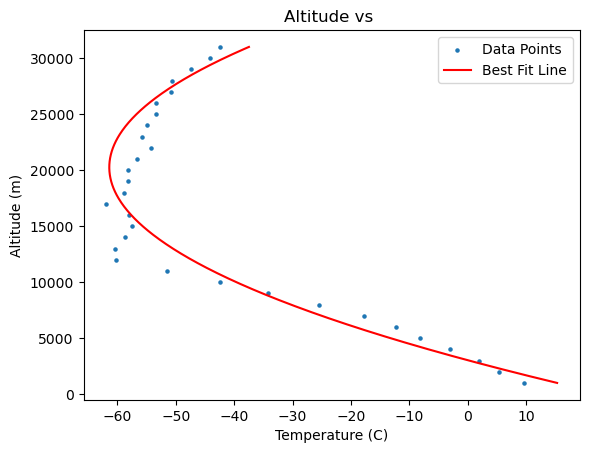

In [31]:
graph2d(resampled_df['Mean Temperature'],resampled_df['Alt'],2 ,'Temperature (C)', 'Altitude (m)', 'Altitude vs ')